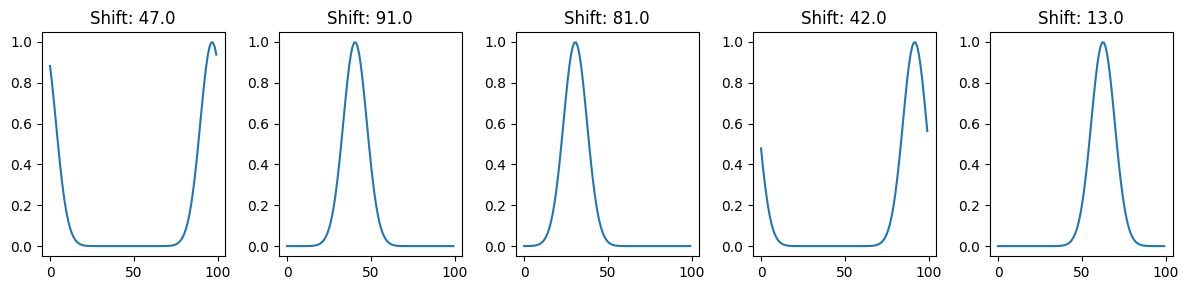

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader

# Create a Gaussian bump template signal
signal_length = 100
x = np.linspace(-5, 5, signal_length)
template_signal = np.exp(-x**2)  # Gaussian bump

# Create dataset of translated signals
class TranslatedSignalDataset(Dataset):
    def __init__(self, template):
        self.template = template
        
        # Generate random shifts
        self.shifts = np.arange(0, signal_length)
        
        # Create translated signals
        self.signals = np.array([np.roll(template, shift) for shift in self.shifts])
        
        # Convert to torch tensors
        self.signals = torch.FloatTensor(self.signals)
        self.shifts = torch.FloatTensor(self.shifts)
        self.n_samples = len(self.signals)
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        return self.signals[idx], self.shifts[idx]

# Create dataset
translated_signals = TranslatedSignalDataset(template_signal)

# Visualize a few examples
plt.figure(figsize=(12, 3))
# Choose 5 random indices between 0 and signal_length-1
random_indices = np.random.choice(signal_length-1, size=5, replace=False)


for i, idx in enumerate(random_indices):
    signal, shift = translated_signals[idx]
    plt.subplot(1, 5, i+1)
    plt.plot(signal.squeeze())
    plt.title(f'Shift: {shift.item():.1f}')
plt.tight_layout()
plt.show()


In [50]:
translated_signals.signals.shape


torch.Size([100, 100])

In [51]:
len(translated_signals[0])

2

In [52]:
translated_signals[0][0].shape

torch.Size([100])

In [65]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_size, encoding_size, alpha=1e-4):
        super(Autoencoder, self).__init__()
        
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 384),
            nn.ReLU(),
            nn.Linear(384, encoding_size),
            nn.ReLU()
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(encoding_size, 384),
            nn.ReLU(),
            nn.Linear(384, 512),
            nn.ReLU(),
            nn.Linear(512, input_size),
        )
        self.alpha = alpha
    def forward(self, x):
        # Flatten input if needed
        x = x.view(x.size(0), -1)
        
        # Encode
        encoded = self.encoder(x)
        
        # Decode
        decoded = self.decoder(encoded)
        
        return self.alpha * decoded


# Create model instance
input_size = translated_signals[0][0].shape[0]  # Get input size from data
print(f"input_size: {input_size}")
model = Autoencoder(input_size=input_size, encoding_size=10)


input_size: 100


In [66]:
torch.cuda.is_available()

True

Epoch [50/500], Loss: 0.093287


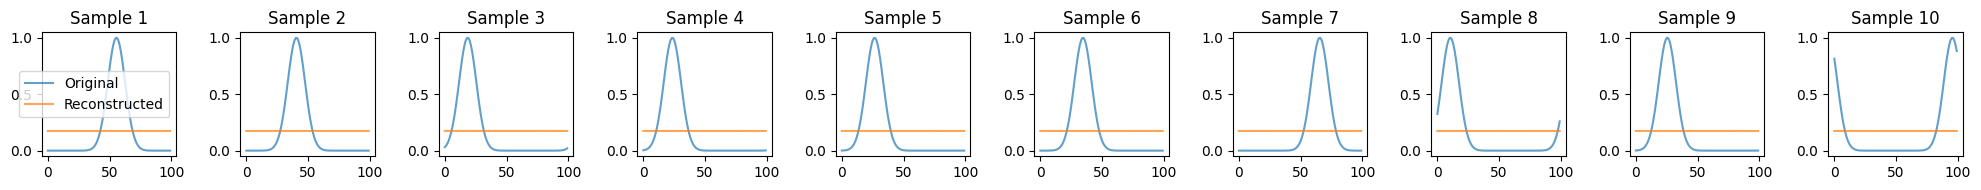

Epoch [100/500], Loss: 0.093287


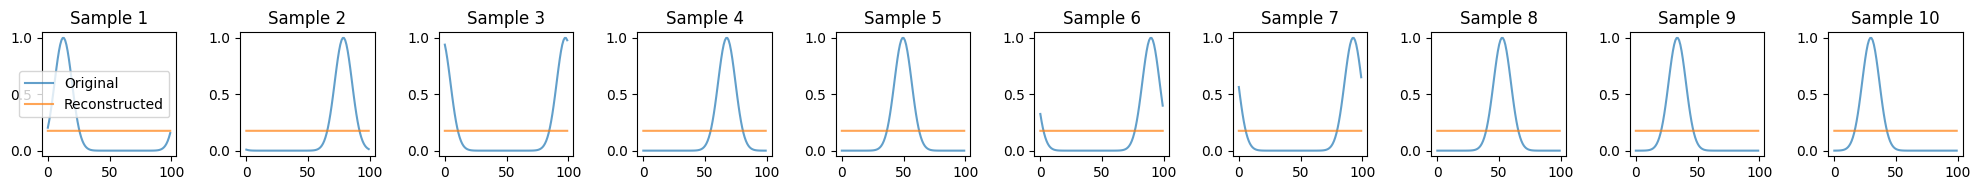

Epoch [150/500], Loss: 0.093287


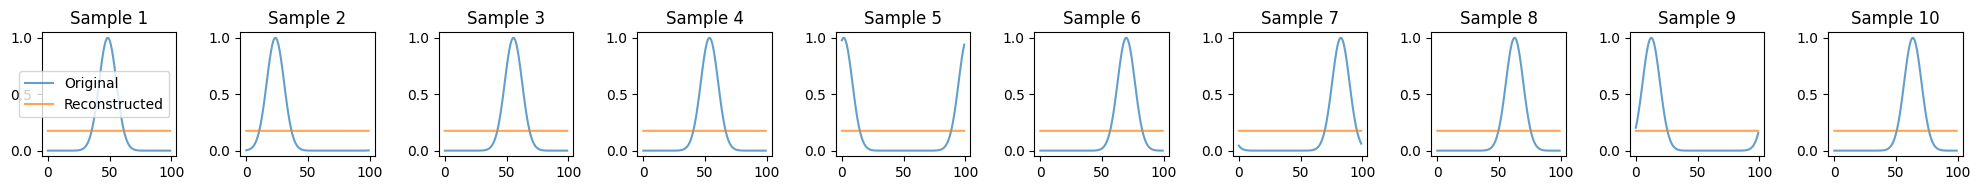

Epoch [200/500], Loss: 0.093256


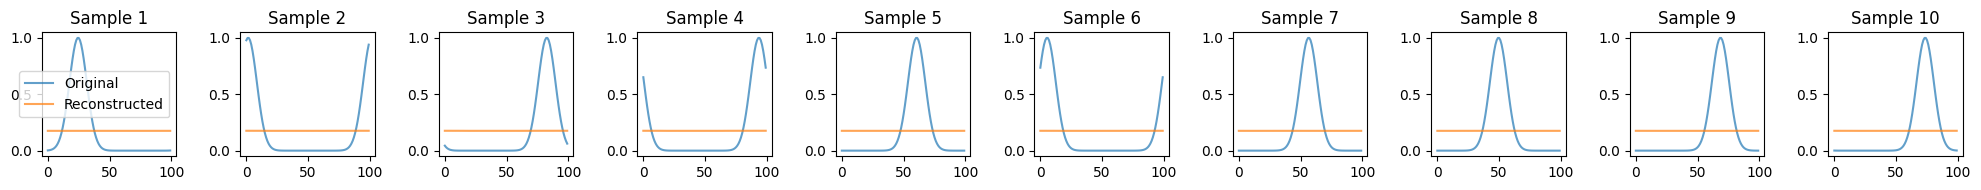

Epoch [250/500], Loss: 0.069808


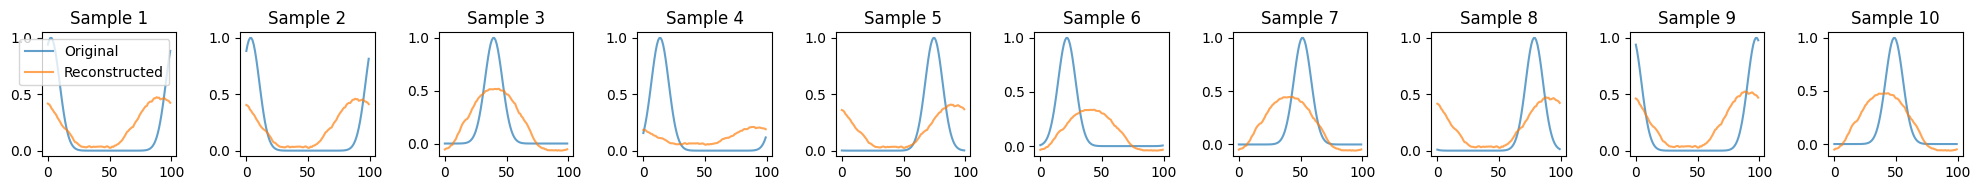

Epoch [300/500], Loss: 0.051475


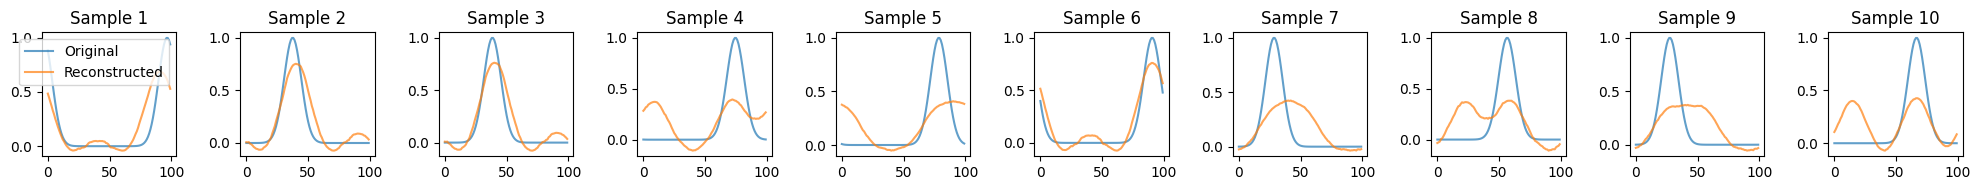

Epoch [350/500], Loss: 0.045623


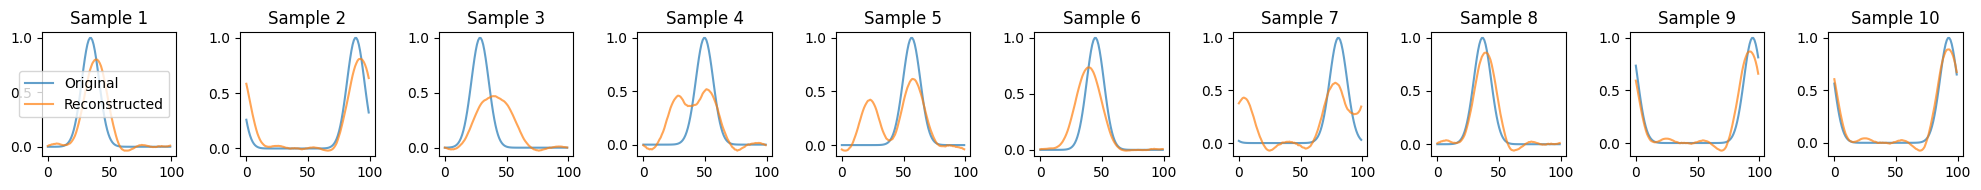

Epoch [400/500], Loss: 0.025051


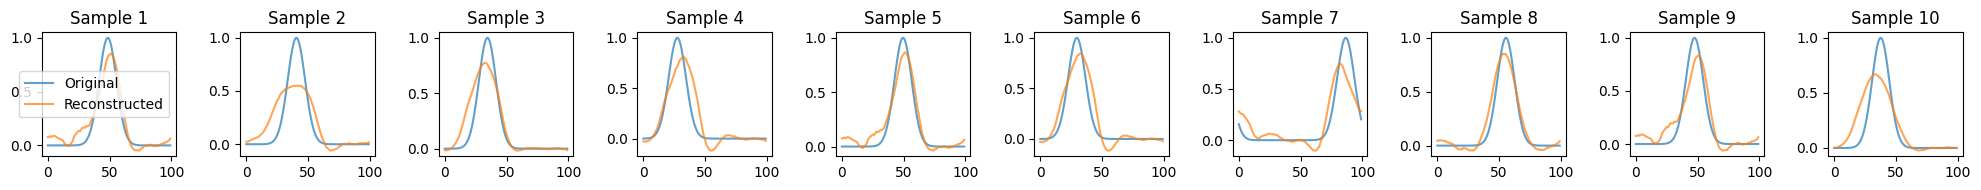

Epoch [450/500], Loss: 0.007667


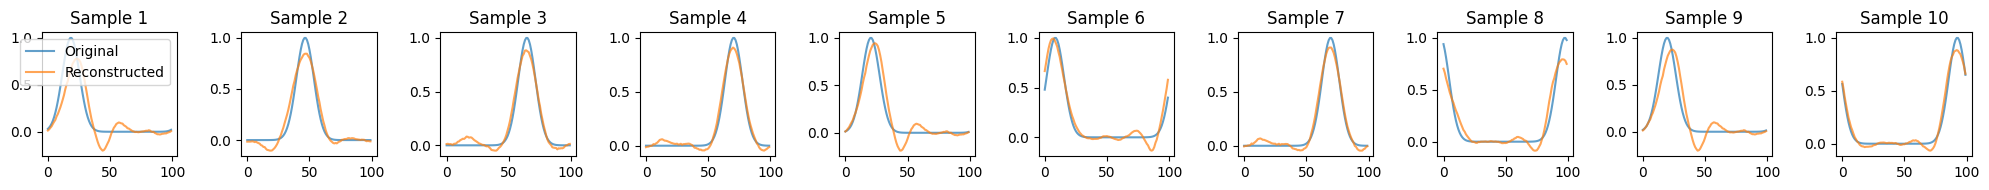

Epoch [500/500], Loss: 0.003588


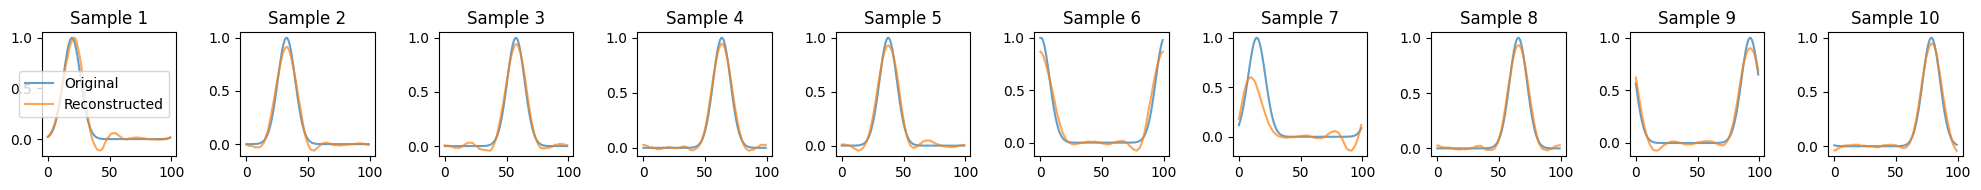

In [69]:
# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(translated_signals, batch_size=132, shuffle=True)


# Lists to store losses
train_losses = []

# Number of epochs
num_epochs = 500

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    num_batches = 0
    
    # Train on each batch
    for batch_idx, (data, _) in enumerate(train_loader):
        # Move data to device
        data = data.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        reconstructed = model(data)
        
        # Calculate loss
        loss = criterion(reconstructed, data)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for epoch
    avg_loss = epoch_loss / num_batches
    train_losses.append(avg_loss)
    
    # Visualization every 10 epochs
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')

        model.eval()
        with torch.no_grad():
            # Get first batch for visualization
            test_data, _ = next(iter(train_loader)) 
            test_data = test_data.to(device)
            reconstructed = model(test_data)
            
            # Create plot
            plt.figure(figsize=(20, 2))
            for i in range(10):
                plt.subplot(1, 10, i+1)
                plt.plot(test_data[i].cpu().numpy(), label='Original', alpha=0.7)
                plt.plot(reconstructed[i].cpu().numpy(), label='Reconstructed', alpha=0.7)
                if i == 0:
                    plt.legend()
                plt.title(f'Sample {i+1}')
            plt.tight_layout()
            plt.show()



Text(0.5, 1.0, 'Training Losses')

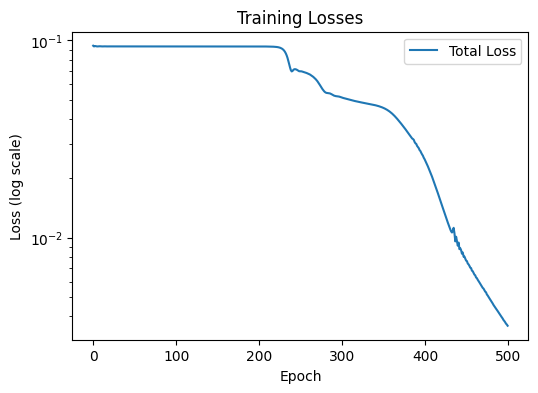

In [70]:
# Final visualization
model.eval()
plt.figure(figsize=(20, 4))

# Plot losses
plt.subplot(131)
plt.semilogy(train_losses, label='Total Loss')  # Changed to semilogy for log scale
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')  # Updated ylabel to indicate log scale
plt.legend()
plt.title('Training Losses')


encoder_weights.shape: (512, 100)
decoder_weights.shape: (100, 512)


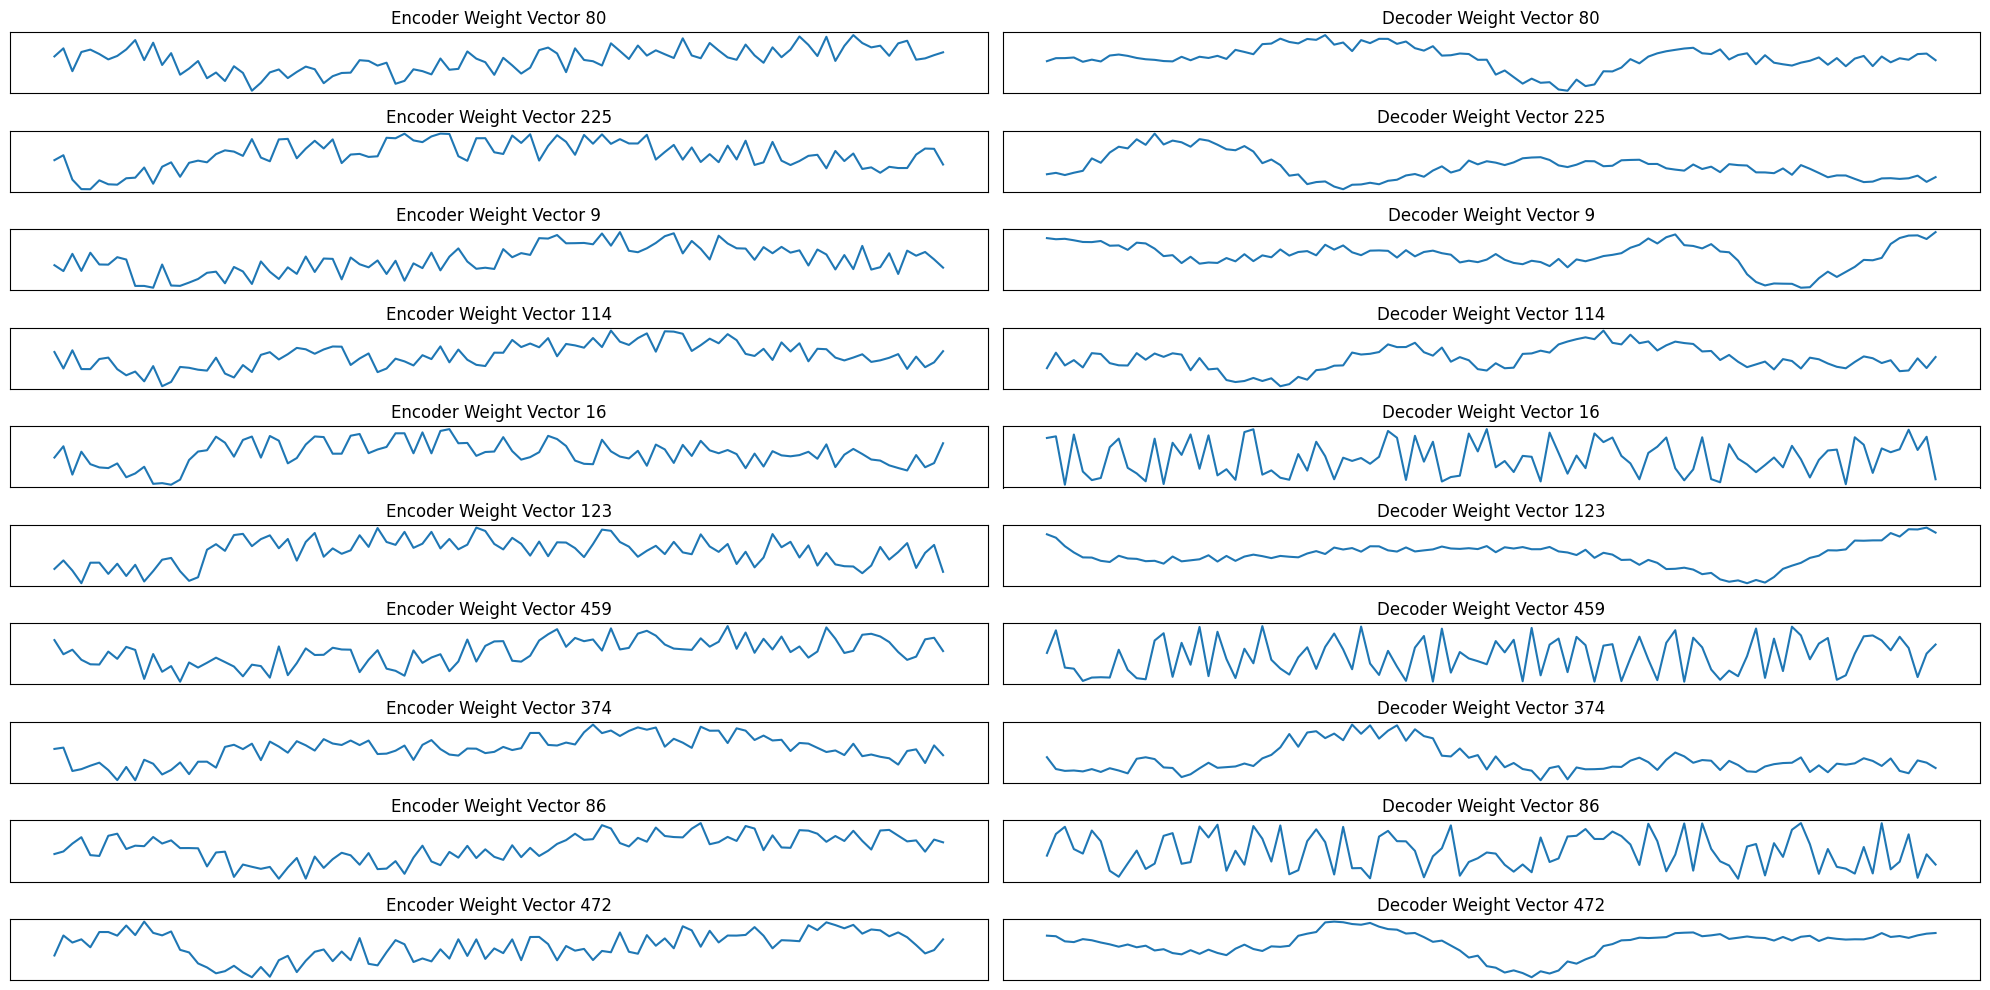

In [84]:
# Number of weight vectors to plot
num_to_plot = 10

# Get encoder and decoder weights
encoder_weights = model.encoder[0].weight.detach().cpu().numpy()
decoder_weights = model.decoder[-1].weight.detach().cpu().numpy()
print(f"encoder_weights.shape: {encoder_weights.shape}")
print(f"decoder_weights.shape: {decoder_weights.shape}")

# Create subplot grid for both encoder and decoder weights
fig = plt.figure(figsize=(20, num_to_plot))

# Randomly select indices to plot
selected_indices = np.random.choice(encoder_weights.shape[0], size=num_to_plot, replace=False)

# Plot encoder weight vectors
for i, idx in enumerate(selected_indices):
    ax = plt.subplot(num_to_plot, 2, 2*i + 1)
    plt.plot(encoder_weights[idx])
    plt.title(f'Encoder Weight Vector {idx+1}')
    plt.grid(True)
    ax.set_xticks([])
    ax.set_yticks([])

# Plot decoder weight vectors  
for i, idx in enumerate(selected_indices):
    ax = plt.subplot(num_to_plot, 2, 2*i + 2)
    plt.plot(decoder_weights[:, idx])
    plt.title(f'Decoder Weight Vector {idx+1}')
    plt.grid(True)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


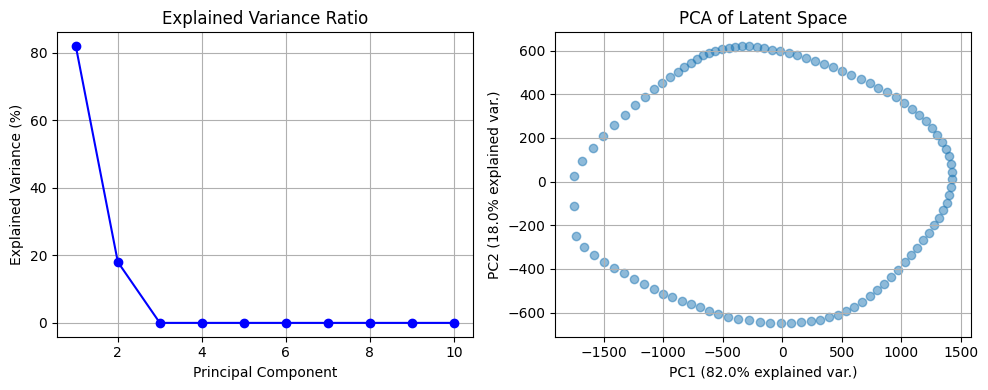

In [87]:
# Get latent representations of the dataset
model.eval()
with torch.no_grad():
    latent_vectors = model.encoder(translated_signals.signals.cuda()).detach().cpu().numpy()

# Perform PCA on latent space
from sklearn.decomposition import PCA
pca = PCA()
latent_pca = pca.fit_transform(latent_vectors)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot explained variance ratios
explained_var = pca.explained_variance_ratio_ * 100  # Convert to percentage
ax1.plot(range(1, len(explained_var) + 1), explained_var, 'bo-')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance (%)')
ax1.set_title('Explained Variance Ratio')
ax1.grid(True)

# Plot first two principal components
ax2.scatter(latent_pca[:, 0], latent_pca[:, 1], alpha=0.5)
ax2.set_xlabel(f'PC1 ({explained_var[0]:.1f}% explained var.)')
ax2.set_ylabel(f'PC2 ({explained_var[1]:.1f}% explained var.)')
ax2.set_title('PCA of Latent Space')
ax2.grid(True)

plt.tight_layout()
plt.show()
